### Importing Libraries

In [1]:
import math
import pandas_datareader as web
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import h5py
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


### Getting Stock Code, Start & End date 

In [2]:
stock_name = input("Enter Stock code: ")
start_date = input("Enter Start date: ")
end_date = input("Enter End date : ")                

Enter Stock code: AAPL
Enter Start date: 1981-01-01
Enter End date : 2020-01-01


### Fetching data from Yahoo-Finance

In [3]:
df = web.DataReader(stock_name, data_source='yahoo', start=start_date, end=end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-12-31,0.611607,0.609375,0.611607,0.609375,8937600.0,0.482832
1981-01-02,0.620536,0.616071,0.616071,0.616071,5415200.0,0.488138
1981-01-05,0.604911,0.602679,0.604911,0.602679,8932000.0,0.477526
1981-01-06,0.578125,0.575893,0.578125,0.575893,11289600.0,0.456303
1981-01-07,0.553571,0.551339,0.553571,0.551339,13921600.0,0.436848
...,...,...,...,...,...,...
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,283.596924
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,289.223602
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,289.113831


In [4]:
print(df.shape)

(9834, 6)


### Plotting the data

C:\Users\Arijit\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


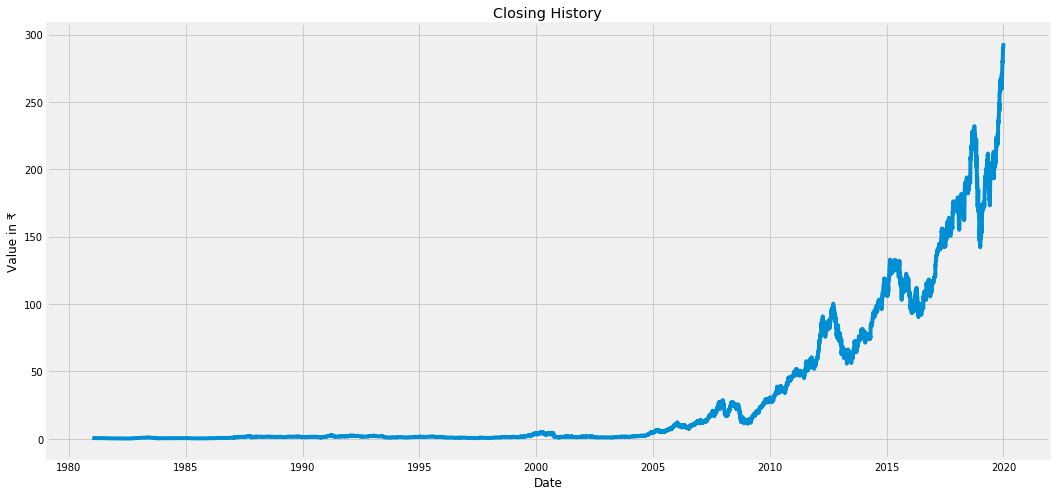

In [5]:
plt.figure(figsize=(16,8))
plt.title("Closing History")
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Value in ₹')
plt.show()

### Copying the 'Close' col.

In [6]:
data = df.filter(['Close'])
dataset = data.values
print(dataset)

[[  0.609375  ]
 [  0.6160714 ]
 [  0.6026786 ]
 ...
 [289.79998779]
 [291.51998901]
 [293.6499939 ]]


### Finding length of 80% of entire data to be used for training

In [7]:
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

7868

### Scaling data

In [8]:
data_normalizer = MinMaxScaler(feature_range=(0,1))
normalized_data = data_normalizer.fit_transform(dataset)
normalized_data

array([[0.0014072 ],
       [0.00143001],
       [0.00138438],
       ...,
       [0.98688036],
       [0.99274159],
       [1.        ]])

In [9]:
training_data = normalized_data[0:training_data_len , :]
x_train = []
y_train = []
for i in range (60 , len(training_data)):
    x_train.append(training_data[i-60:i , 0])
    y_train.append(training_data[i , 0])
    """
    if (i <= 61):
        print(x_train)
        print(y_train)
        print("\n")
    """

### Converting lists to NumPy arrays

In [10]:
x_train = np.array(x_train)
y_train = np.array(y_train)

#### Reshaping 2-D NumPy array to 3-D numpy array

In [11]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1] ,1))
x_train.shape

(7808, 60, 1)

### Model Defination

In [12]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

### Model Compilation

In [13]:
model.compile(optimizer='adam',loss='mean_squared_error')

### Training the model

In [14]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

Epoch 1/1
7808/7808 [==============================] - 439s 56ms/step - loss: 4.6340e-05


### Preparing test data

In [15]:
test_data = normalized_data [training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len: , :]
for i in range (60,len(test_data)):
    x_test.append(test_data[i-60:i , 0])

In [16]:
x_test = np.array(x_test)

In [17]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

(1966, 60, 1)

In [18]:
predictions = model.predict(x_test)
predictions = data_normalizer.inverse_transform(predictions)

### Finding Root-Mean-Squared-Error

In [19]:
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.02582042651404442

### Plotting Predicted Curve

C:\Users\Arijit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


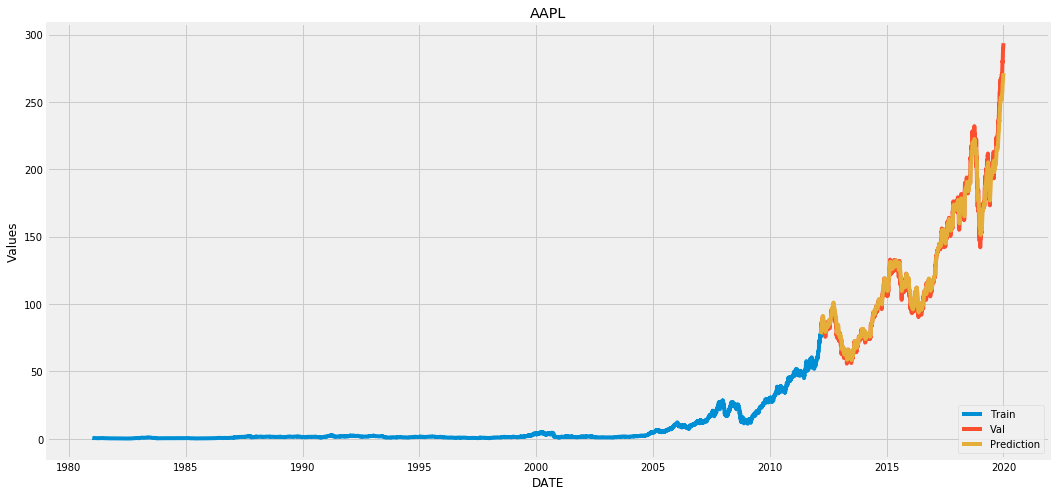

In [20]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title(stock_name)
plt.xlabel("DATE")
plt.ylabel("Values")
plt.plot(train['Close'])
plt.plot(valid[["Close",'Predictions']])
plt.legend(['Train','Val','Prediction'], loc = 'lower right')
plt.savefig(stock_name + ".png")
plt.show()

In [21]:
print(valid)

                 Close  Predictions
Date                               
2012-03-09   77.881432    77.608292
2012-03-12   78.857140    78.010872
2012-03-13   81.157143    78.593483
2012-03-14   84.225716    79.612152
2012-03-15   83.651428    81.203957
...                ...          ...
2019-12-24  284.269989   265.433044
2019-12-26  289.910004   266.464294
2019-12-27  289.799988   268.416351
2019-12-30  291.519989   269.977875
2019-12-31  293.649994   271.414795

[1966 rows x 2 columns]


In [22]:
valid.to_excel(stock_name+".xlsx")

In [23]:
quote = web.DataReader(stock_name,data_source='yahoo',start=start_date, end='2020-02-27')
new_df = quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_normalized = data_normalizer.transform(last_60_days)
new_x_test = []
new_x_test.append(last_60_days_normalized)
new_x_test = np.array(new_x_test)
new_x_test - np.reshape(new_x_test, (new_x_test.shape[0],new_x_test.shape[1],1))
future_prediction = model.predict(new_x_test)
future_prediction = data_normalizer.inverse_transform(future_prediction)
print(future_prediction)

[[275.0874]]
